# Penerapan PCA dan ADASYN pada Dataset Ecoli  

Ketentuan Tugas:  
- Tampilkan data dalam scatter plot menggunakan PCA. PCA mentransformasi data menjadi dimensi rendah (2D).
- Lakukan penyeimbangan data menggunakan ADASYN.
- Ploting data dari data yang diimbangkan menggunakan PCA, tandai data data hasil generatenya.

## Import Library

In [1]:
import pandas as pd
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN, RandomOverSampler
from collections import Counter

## Koneksi ke MySQL dan Ambil Dataset

In [2]:
# Koneksi ke MySQL
mysql_conn = pymysql.connect(
    host="mysql-3c768195-aqbilbaraka.d.aivencloud.com",
    user="avnadmin",
    password="AVNS_WV9i6KvYoQZ3s6FclWP",
    database="defaultdb",
    port=16932,
    ssl={"ssl": {}}
)

# Query tabel ecoli
query_mysql = "SELECT * FROM defaultdb.ecoli"
df = pd.read_sql(query_mysql, mysql_conn)

# Lihat data
df.head()


C:\Users\acer\AppData\Local\Temp\ipykernel_8324\255578765.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query_mysql, mysql_conn)


,id,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,1,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,2,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,3,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,4,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,5,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


## Identifikasi fitur & label, pembersihan ringan

In [3]:
# Identifikasi kolom non-numeric
print("Kolom & dtypes:")
print(df.dtypes)

# Cari kolom label (kelas). Logika: pilih kolom bertipe object/string dengan nunique < n
possible_labels = [c for c in df.columns if df[c].dtype == object or df[c].dtype.name == 'category']
label_col = None
for c in possible_labels:
    if df[c].nunique() < len(df):
        label_col = c
        break

# Jika tidak ketemu, kamu harus set manual
if label_col is None:
    # contohnya: label_col = 'class'    # ganti jika perlu
    raise ValueError("Tidak menemukan kolom label otomatis. Set 'label_col' manual sesuai dataset (mis. 'class').")

print("Terpilih sebagai label:", label_col)

# Pilih fitur numerik (exclude id / label)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Kadang dataset UCI menyertakan index/sequence name sebagai kolom object unik - pastikan mengeluarkannya
print("Kolom numerik digunakan untuk PCA/ADASYN:", num_cols)

Kolom & dtypes:
id         int64
mcg      float64
gvh      float64
lip      float64
chg      float64
aac      float64
alm1     float64
alm2     float64
class     object
dtype: object
Terpilih sebagai label: class
Kolom numerik digunakan untuk PCA/ADASYN: ['id', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']


## Pra-pemrosesan fitur: drop missing, scale, encode label

In [4]:
# Buat salinan kerja
df_proc = df.copy()

# Drop rows dengan missing pada fitur numerik (atau lakukan imputasi bila ingin)
df_proc = df_proc.dropna(subset=num_cols)
print("After dropna shape:", df_proc.shape)
label_col = df.columns[-1]

# X (fitur numerik) dan y (label)
X = df_proc[num_cols].values
y = df_proc[label_col].values

# Encode label ke integer untuk ADASYN & plotting
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_
print("Class mapping:", dict(enumerate(class_names)))

# Standardize fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


After dropna shape: (336, 9)
Class mapping: {0: 'cp', 1: 'im', 2: 'imL', 3: 'imS', 4: 'imU', 5: 'om', 6: 'omL', 7: 'pp'}


## Preprocessing Data

In [5]:
# Pisahkan fitur & target
X = df.drop(columns=["class"])
y = df["class"]

# Encode label target (class → angka)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Distribusi awal:", Counter(y_enc))


Distribusi awal: Counter({0: 143, 1: 77, 7: 52, 4: 35, 5: 20, 6: 5, 3: 2, 2: 2})


## PCA 2D & scatter plot (sebelum balancing)

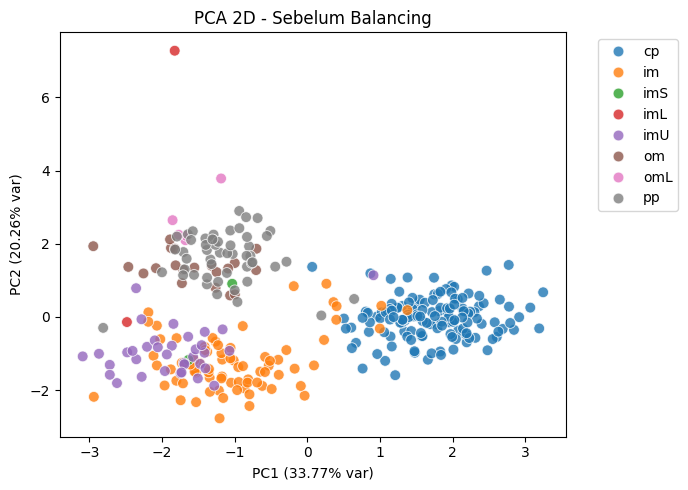

In [6]:
# Fit PCA pada data asli (2 komponen)
pca = PCA(n_components=2, random_state=42)
X_pca_before = pca.fit_transform(X_scaled)   # <<< ini yang belum ada

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=X_pca_before[:,0], y=X_pca_before[:,1],
    hue=y, palette="tab10", s=60, edgecolor="w", alpha=0.8
)
plt.title("PCA 2D - Sebelum Balancing")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% var)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

## Cek distribusi kelas sebelum balancing

In [7]:
orig_counts = pd.Series(y).value_counts()
print("Counts before balancing:")
print(orig_counts)


Counts before balancing:
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: count, dtype: int64


## Lakukan balancing menggunakan ADASYN

### Sebelum Resampling

In [8]:
print("Distribusi sebelum:", Counter(y_enc))

Distribusi sebelum: Counter({0: 143, 1: 77, 7: 52, 4: 35, 5: 20, 6: 5, 3: 2, 2: 2})


### Step 1: RandomOverSampler dulu → agar kelas minoritas punya cukup data


In [9]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_scaled, y_enc)

print("Distribusi setelah ROS:", Counter(y_ros))

Distribusi setelah ROS: Counter({0: 143, 1: 143, 3: 143, 2: 143, 4: 143, 5: 143, 6: 143, 7: 143})


### Step 2: ADASYN → membuat synthetic samples


In [10]:
adasyn = ADASYN(random_state=42, n_neighbors=1)  # n_neighbors=1 agar aman
X_res, y_res = adasyn.fit_resample(X_ros, y_ros)

print("Shape sebelum:", X_scaled.shape, "→ sesudah:", X_res.shape)
print("Distribusi sesudah ADASYN:", Counter(y_res))

Shape sebelum: (336, 8) → sesudah: (1144, 8)
Distribusi sesudah ADASYN: Counter({0: 143, 1: 143, 3: 143, 2: 143, 4: 143, 5: 143, 6: 143, 7: 143})


## Visualisasi PCA Sesudah Balancing

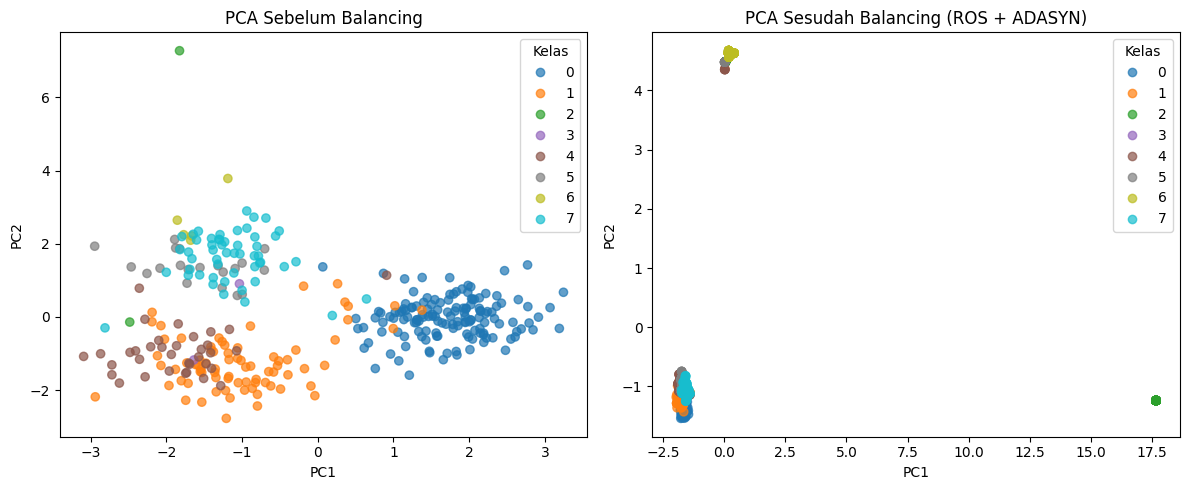

In [11]:
# Transformasi PCA
X_pca_after = pca.fit_transform(X_res)

plt.figure(figsize=(12,5))

# Sebelum balancing
plt.subplot(1,2,1)
scatter1 = plt.scatter(X_pca_before[:,0], X_pca_before[:,1], 
                       c=y_enc, cmap="tab10", alpha=0.7)
plt.title("PCA Sebelum Balancing")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(*scatter1.legend_elements(), title="Kelas")

# Sesudah balancing
plt.subplot(1,2,2)
scatter2 = plt.scatter(X_pca_after[:,0], X_pca_after[:,1], 
                       c=y_res, cmap="tab10", alpha=0.7)
plt.title("PCA Sesudah Balancing (ROS + ADASYN)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(*scatter2.legend_elements(), title="Kelas")

plt.tight_layout()
plt.show()


## Perbandingan Distribusi Kelas Sebelum dan Sesudah Balancing

### Barplot

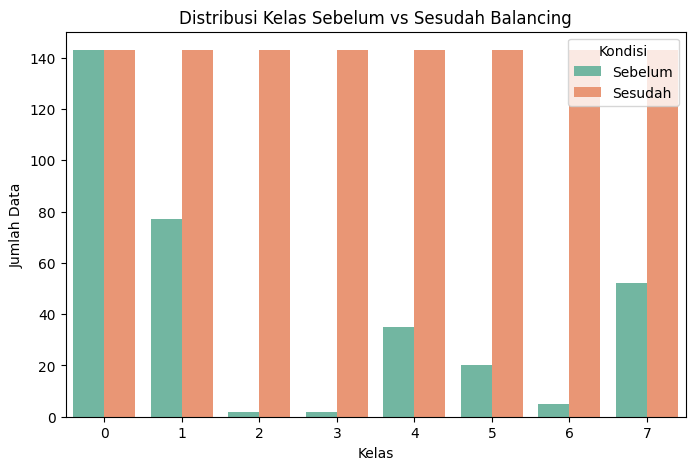

Distribusi sebelum balancing: Counter({0: 143, 1: 77, 7: 52, 4: 35, 5: 20, 6: 5, 3: 2, 2: 2})
Distribusi sesudah balancing: Counter({0: 143, 1: 143, 3: 143, 2: 143, 4: 143, 5: 143, 6: 143, 7: 143})


In [12]:
import seaborn as sns

# Hitung distribusi kelas
from collections import Counter
dist_before = Counter(y_enc)
dist_after = Counter(y_res)

# Konversi ke DataFrame biar enak diplot
df_dist = pd.DataFrame({
    "Kelas": list(dist_before.keys()),
    "Sebelum": list(dist_before.values()),
    "Sesudah": [dist_after[k] for k in dist_before.keys()]
})

# Plot side-by-side
df_melted = df_dist.melt(id_vars="Kelas", var_name="Kondisi", value_name="Jumlah")

plt.figure(figsize=(8,5))
sns.barplot(data=df_melted, x="Kelas", y="Jumlah", hue="Kondisi", palette="Set2")
plt.title("Distribusi Kelas Sebelum vs Sesudah Balancing")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.show()

print("Distribusi sebelum balancing:", dist_before)
print("Distribusi sesudah balancing:", dist_after)


### Pairplot PCA

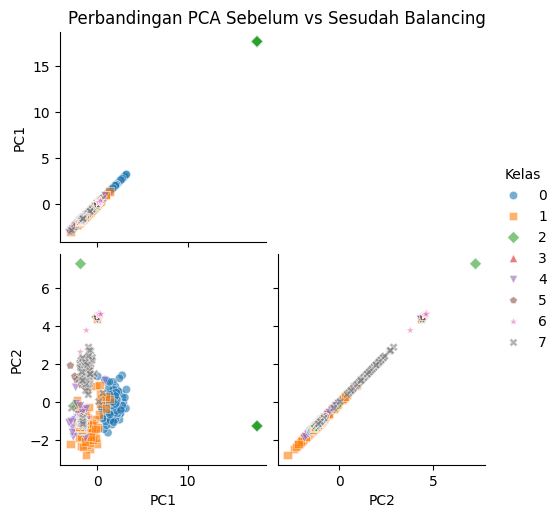

In [13]:
# Buat dataframe gabungan sebelum & sesudah
df_before = pd.DataFrame(X_pca_before, columns=["PC1","PC2"])
df_before["Kelas"] = y_enc
df_before["Status"] = "Sebelum"

df_after = pd.DataFrame(X_pca_after, columns=["PC1","PC2"])
df_after["Kelas"] = y_res
df_after["Status"] = "Sesudah"

df_compare = pd.concat([df_before, df_after])

# Pairplot perbandingan
sns.pairplot(df_compare, hue="Kelas", diag_kind=None, kind="scatter", 
             markers=["o","s","D","^","v","p","*","X"], 
             palette="tab10", corner=True, height=2.5, 
             plot_kws={"alpha":0.6})
plt.suptitle("Perbandingan PCA Sebelum vs Sesudah Balancing", y=1.02)
plt.show()


### t-SNE Visualization

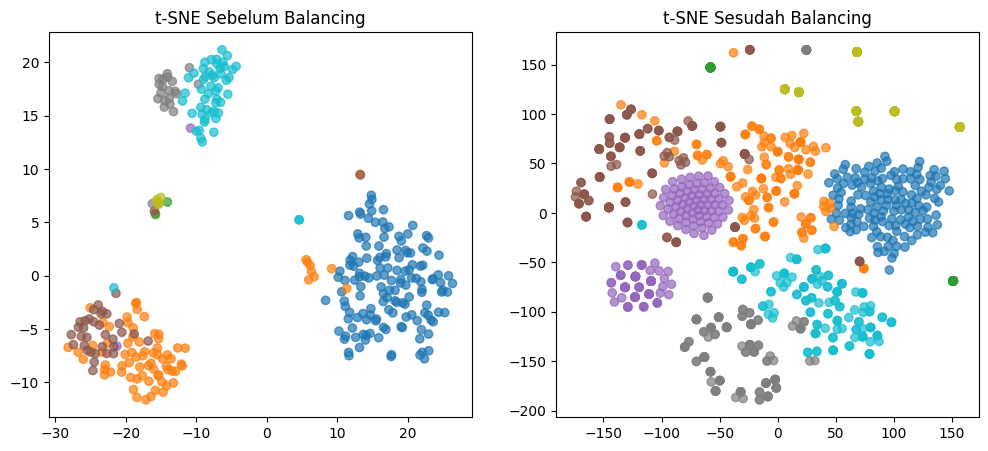

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

# Transform data
X_tsne_before = tsne.fit_transform(X_scaled)
X_tsne_after = tsne.fit_transform(X_res)

# Plot sebelum
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_tsne_before[:,0], X_tsne_before[:,1], c=y_enc, cmap="tab10", alpha=0.7)
plt.title("t-SNE Sebelum Balancing")

# Plot sesudah
plt.subplot(1,2,2)
plt.scatter(X_tsne_after[:,0], X_tsne_after[:,1], c=y_res, cmap="tab10", alpha=0.7)
plt.title("t-SNE Sesudah Balancing")
plt.show()


### Heatmap Distribusi Kelas

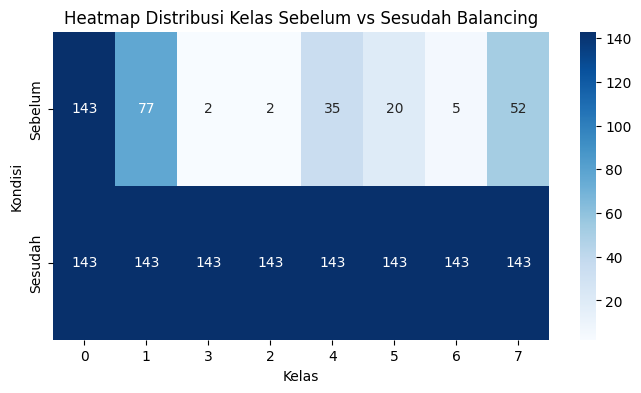

In [15]:
# Buat dataframe distribusi
df_heat = pd.DataFrame({
    "Sebelum": dist_before,
    "Sesudah": dist_after
}).T

plt.figure(figsize=(8,4))
sns.heatmap(df_heat, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap Distribusi Kelas Sebelum vs Sesudah Balancing")
plt.xlabel("Kelas")
plt.ylabel("Kondisi")
plt.show()


### Pie Chart Distribusi Kelas

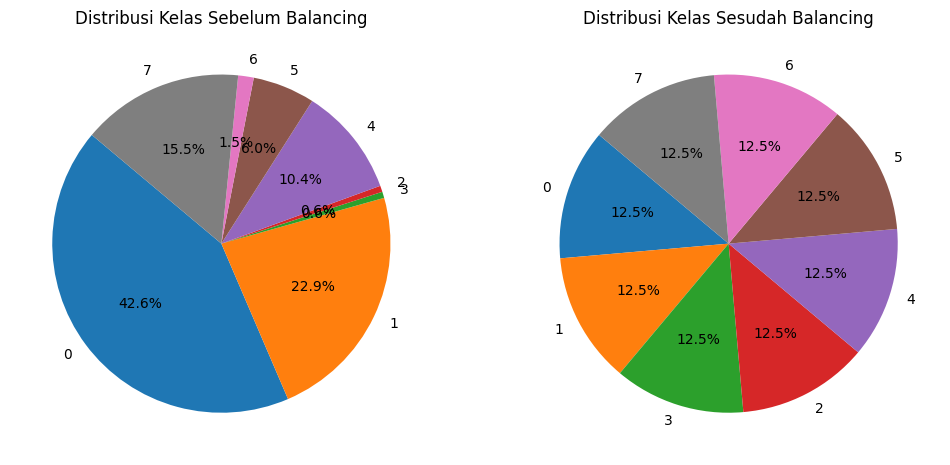

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Sebelum
axes[0].pie(list(dist_before.values()), labels=list(dist_before.keys()), 
            autopct='%1.1f%%', startangle=140, colors=sns.color_palette("tab10"))
axes[0].set_title("Distribusi Kelas Sebelum Balancing")

# Sesudah
axes[1].pie(list(dist_after.values()), labels=list(dist_after.keys()), 
            autopct='%1.1f%%', startangle=140, colors=sns.color_palette("tab10"))
axes[1].set_title("Distribusi Kelas Sesudah Balancing")

plt.show()
